In [78]:
!pip install wbdata

import wbdata
import pandas as pd

# Overview: Population Trends of India: 1960 - Present

In [79]:
# construct a list of age-ranges.
age_ranges = []

# 5-year ranges, top up at 80 
for i in range(0,80,5):
    age_ranges.append(f"{i:02d}"+f"{i+4:02d}")
age_ranges.append("80UP")

# construct dictionary of sex and age ranges
male_variables = {"SP.POP."+age_range+".MA":"males "+age_range for age_range in age_ranges}
female_variables = {"SP.POP."+age_range+".FE":"females "+age_range for age_range in age_ranges}
variables = male_variables
variables.update(female_variables)

# Population Functions

In [80]:
# function that returns population number of a specific year, sex, age range, and country
def population(year, sex, age_group, country):
    
    # retrieve data frame of the specified country
    country_label = wbdata.search_countries(country)[0]['id']
    # select the specified year
    df = wbdata.get_dataframe(variables,country=country_label).loc[[str(year)]]
    
    # truncate ages above 80
    age_group = list(age_group)
    if age_group[1] > 80:
        age_group[1] = 80
    
    # select data frame indices for the specified age group
    # for males
    if sex == 'male':
        start_idx = age_group[0] // 5
        end_idx = age_group[1] // 5 + 1
        
        df2 = df.iloc[:, start_idx:end_idx]
        
    # for females
    if sex == 'female':
        start_idx = age_group[0] // 5 + len(df.columns)//2
        end_idx = age_group[1] // 5 + 1 + len(df.columns)//2
        df2 = df.iloc[:, start_idx:end_idx]

    # for both sexes
    if sex == 'people':
        start_idx_m = age_group[0] // 5
        end_idx_m = age_group[1] // 5 + 1
        start_idx_f = age_group[0] // 5 + len(df.columns)//2
        end_idx_f = age_group[1] // 5 + 1 + len(df.columns)//2

        df2 = df.iloc[:, start_idx_m:end_idx_m]
        df3 = df.iloc[:, start_idx_f:end_idx_f]
    
    # adjust for partial (non 5-year) age ranges
    # assuming population with a 5-year range is evenly distributed
    if len(df2.columns) == 1:
        df2.iloc[0, 0] = df2.iloc[0, 0] / 5 * (age_group[1]-age_group[0]+1)
    else:
        lower_gap = age_group[0] % 5
        upper_gap = age_group[1] % 5
        df2.iloc[0, 0] = df2.iloc[0, 0] / 5 * (5-lower_gap)
        df2.iloc[0, -1] = df2.iloc[0, -1] / 5 * (upper_gap + 1)
    
    if sex == 'people':
        if len(df3.columns) == 1:
            df3.iloc[0, 0] = df3.iloc[0, 0] / 5 * (age_group[1]-age_group[0]+1)
        else:
            df3.iloc[0, 0] = df3.iloc[0, 0] / 5 * (5-lower_gap)
            df3.iloc[0, -1] = df3.iloc[0, -1] / 5 * (upper_gap + 1)
        df2 = df2.join(df3)
    
    # calculate sum of population in all selected age ranges
    sum = df2.sum(axis='columns')[0]
    
    return sum
    

In [81]:
# test
df = population(year = 2020, sex = 'people', age_group = (5,10) , country = 'India')
df

147328325.4

In [82]:
# function that returns a dataframe of country, year, age range, population by sex, and total population
def population_df(year, country):
    
    # retrieve data frame of the specified country
    country_label = wbdata.search_countries(country)[0]['id']
    # select the specific year
    df = wbdata.get_dataframe(variables,country=country_label).loc[[str(year)]]
    
    # transform data frame and add elements
    df = df.transpose()
    pop_df = pd.DataFrame({'Country': country,'Year': year,'Age Range': age_ranges,
        'Male': df.iloc[0:int(len(df)/2),0].tolist(), 'Female': df.iloc[int(len(df)/2):len(df),0].tolist()})
    pop_df['Total'] = pop_df['Male'] + pop_df['Female']
    
    return pop_df

In [83]:
# test
pop_df = population_df(year=2000, country='France')
pop_df

,Country,Year,Age Range,Male,Female,Total
0,France,2000,0004,1909500.0,1817413.0,3726913.0
1,France,2000,0509,1906038.0,1816368.0,3722406.0
2,France,2000,1014,2022498.0,1929786.0,3952284.0
3,France,2000,1519,2062243.0,1983172.0,4045415.0
4,France,2000,2024,1958209.0,1930689.0,3888898.0
5,France,2000,2529,2146517.0,2149435.0,4295952.0
6,France,2000,3034,2162080.0,2182337.0,4344417.0
7,France,2000,3539,2202826.0,2246159.0,4448985.0
8,France,2000,4044,2152835.0,2211442.0,4364277.0
9,France,2000,4549,2154636.0,2197595.0,4352231.0


# Population Pyramids

In [84]:
# visualize population pyramid of India in year 2010
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np

py.init_notebook_mode(connected=True)


# get population dataframe
pop_df = population_df(year=2010, country='India')

# specify layout
layout = go.Layout(barmode='overlay',
                   yaxis=go.layout.YAxis(range=[0, 90], title='Age'),
                   xaxis=go.layout.XAxis(title='Number'),
                   title_text=f"Population Pyramid of India, 2010")

bins = [go.Bar(x = pop_df['Male'],
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Men',
               marker=dict(color='purple'),
               hoverinfo='skip'
               ),
        go.Bar(x = -pop_df['Female'],
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Women',
               marker=dict(color='pink'),
               hoverinfo='skip'
               )
       ]

fig = go.Figure(data=bins, layout=layout)
fig.show()

In [85]:
# visualize an animated population pyramid of India, 1960-2020

# create initial plot
year_init = 1960
# get population dataframe
pop_df = population_df(year=year_init, country='India')

# specify layout
layout = go.Layout(barmode='overlay',
                   yaxis=go.layout.YAxis(range=[0, 90], title='Age'),
                   xaxis=go.layout.XAxis(title='Number'),
                  title_text=f"Population Pyramid Animation")

bins = [go.Bar(x = pop_df['Male'],
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Men',
               marker=dict(color='purple'),
               hoverinfo='skip'
               ),
        go.Bar(x = -pop_df['Female'],
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Women',
               marker=dict(color='pink'),
               hoverinfo='skip'
               )
       ]

# create multiple pyramids as frames for animation
years = range(1960,2030,10)

frames = []
for y in years:
    
    # get population dataframe
    pop_df = population_df(year=y, country='India')

    # update the bins
    bins = [go.Bar(x = pop_df['Male'],
                   y = [int(s[:2])+1 for s in age_ranges],
                   orientation='h',
                   name='Men',
                   marker=dict(color='purple'),
                   hoverinfo='skip'
                   ),
            go.Bar(x = -pop_df['Female'],
                   y = [int(s[:2])+1 for s in age_ranges],
                   orientation='h',
                   name='Women',
                   marker=dict(color='pink'),
                   hoverinfo='skip'
                   )
            ]
    # create the button
    button = {
        "type": "buttons",
        "buttons": [
            {
                "label": "Play",
                "method": "animate",
                "args": [None, {"frame": {"duration": 1000}}],
            }
        ],
    }
    layout = go.Layout(barmode='overlay',
                   yaxis=go.layout.YAxis(range=[0, 90], title='Age'),
                   xaxis=go.layout.XAxis(title='Number'), updatemenus=[button], 
                    title_text=f"Population Pyramid Animation")
    
    # create frames
    frame = go.Frame(data=bins, layout=go.Layout(title_text=f"Population Pyramid in Year {y}"))
    frames.append(frame)
    


fig = go.Figure(data=bins,
                frames=frames,
                layout = layout)
                                 
# show animation
fig.show()

In [87]:
# visualize population size over time in India, 1960-2020

import cufflinks as cf

variable_labels = {"SP.POP.TOTL":"World Population"}

IND_DATA = wbdata.get_dataframe(variable_labels, country="IND")

# Date index is of type string; change to integers
IND_DATA.index = IND_DATA.index.astype(int)

cf.go_offline()

IND_DATA.index = IND_DATA.index.astype(int)
IND_DATA.head()

IND_DATA.iplot(title="Population Size in India 1960-2020",yTitle='Population',xTitle='Year')


# Population Growth and Agricultural Production

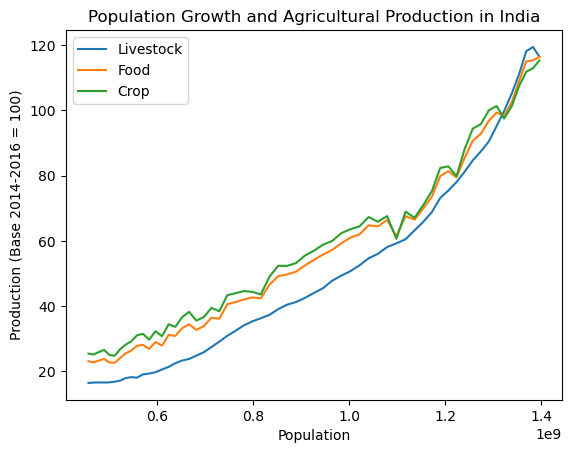

In [89]:
# visualize population growth and agricultural production in India

vars = {"AG.PRD.LVSK.XD":"Livestock index",
        "AG.PRD.FOOD.XD":"Food index",
        "AG.PRD.CROP.XD":"Crop index",
        "SP.POP.TOTL":"Population"}


ag = wbdata.get_dataframe(vars,country='IND')
ag = ag.reset_index()
ag['date'] = ag['date'].astype(int)

lvsk = plt.plot('Population', 'Livestock index', data=ag, label='Livestock')
food = plt.plot('Population', 'Food index', data=ag, label='Food')
crop = plt.plot('Population', 'Crop index', data=ag, label='Crop')
plt.xlabel('Population')
plt.ylabel('Production (Base 2014-2016 = 100)')
plt.title("Population Growth and Agricultural Production in India")
plt.legend()

In [90]:
# visualize food growth rate and population growth rate, 1960-2020
import plotly.express as px

#plt.plot(ag['date'], np.log(ag['Population']))
#plt.plot(ag['date'], ag['Food index'])
ag_idx = ag.set_index(ag['date']).drop(columns=['date'])
ag_asc = ag_idx.sort_index()
rates = np.log(ag_asc).diff().dropna()
#rates
px.scatter(rates, 
           x=rates.index, 
           y=['Population', 'Food index'], 
           labels={
               'value': 'Growth Rate (per year)',
               'date': 'Year'
           },
           title='Growth Rate of Food versus Population in India 1960-2020',
           trendline='ols')#, data=pop_growth_rate)
#px.scatter(rates, x=rates.index, y='Food index', trendline='ols')#, data=pop_growth_rate)

# Slow Down of Population Growth and Expansion of Women's Education

In [91]:
# function to retrieve population growth data in a specific country
def growth_df(region):
    df=wbdata.get_dataframe({'SP.POP.GROW': 'Total Population growth (annual %)',
                            'SP.RUR.TOTL.ZG': 'Rural population growth (annual %)',
                            'SP.URB.GROW': 'Urban population growth (annual %)'}, country=region)
    df.index = df.index.rename('year')
    df.index = df.index.astype(int)
    return df

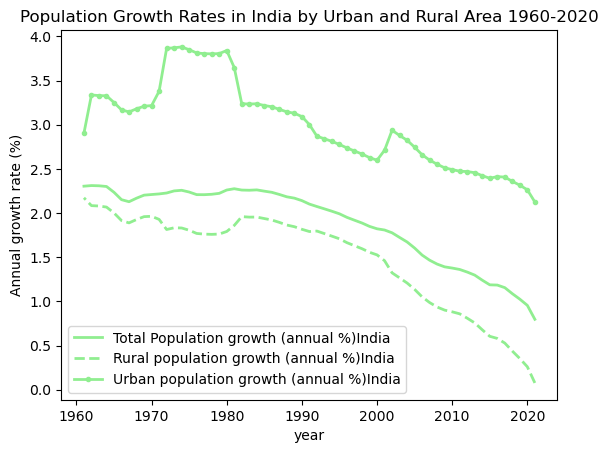

In [92]:
# visualize population growth rate by urban and rural areas in India, 1960-2020
import matplotlib.pyplot as plt

ind_gr = growth_df('IND')
def urb_rur_plot(df, India, color):
    fig = plt.figure()
    ax = plt.axes() 
     
    plt.plot(ind_gr.index, ind_gr.iloc[:, 0],  color='lightgreen',linewidth=2)
    plt.plot(ind_gr.index, ind_gr.iloc[:, 1],  '--', color='lightgreen',linewidth=2)
    plt.plot(ind_gr.index, ind_gr.iloc[:, 2],  '.-', color='lightgreen', linewidth=2);
    ax.legend((df.columns+India).append(ind_gr.columns))

    plt.title('Population Growth Rates in India by Urban and Rural Area 1960-2020')
    plt.xlabel('year')
    plt.ylabel('Annual growth rate (%)')

urb_rur_plot(ind_gr, "India", 'green')

In [93]:
# visualize the trend of fertility and mortality rates in India, 1960-2020
IND_Birth_Death = wbdata.get_dataframe({'SP.DYN.CBRT.IN': 'Fertility rate % (per 1,000 people)',
                            'SP.DYN.CDRT.IN': 'Mortality rate % (per 1,000 people)'}, country="IND")
                                       
IND_Birth_Death.index = IND_Birth_Death.index.rename('year')
IND_Birth_Death.index = IND_Birth_Death.index.astype(int)   
IND_Birth_Death.iplot(title="Fertility and Mortality Rates in India 1960-2020",yTitle='Population',xTitle='Year')

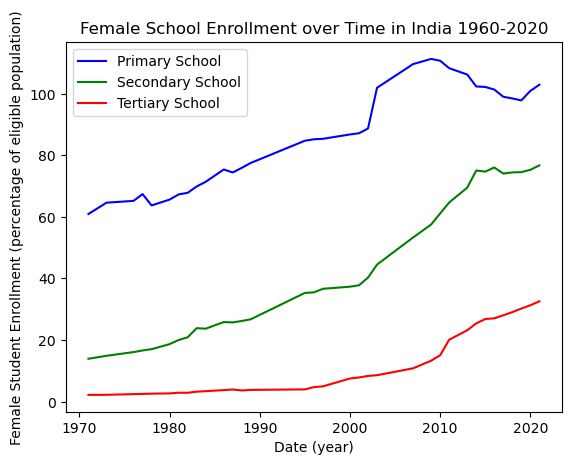

In [94]:
# visualize trend of female education, proxied by primary, secondary, and tertiary school enrollment

vars = {"SE.PRM.ENRR.FE":"Female Primary School Enrollment",
        "SE.SEC.ENRR.FE":"Female Secondary School Enrollment",
        "SE.TER.ENRR.FE":"Female Tertiary School Enrollment"}


se_com = wbdata.get_dataframe(vars,country='IND')
se_com = se_com.reset_index()
se_com['date'] = se_com['date'].astype(int)
se_com = se_com.dropna()

se_com_pr = plt.plot('date', 'Female Primary School Enrollment', data=se_com, label='Primary School', color='blue')
se_com_sec = plt.plot('date', 'Female Secondary School Enrollment', data=se_com, label='Secondary School', color='green')
se_com_ter = plt.plot('date', 'Female Tertiary School Enrollment', data=se_com, label='Tertiary School', color='red')
plt.xlabel('Date (year)')
plt.ylabel('Female Student Enrollment (percentage of eligible population)')
plt.title('Female School Enrollment over Time in India 1960-2020')
plt.legend()

In [95]:
# retrieve and prepare school enrollment data

vars = {"SE.PRM.ENRR.FE":"Female Primary School Enrollment"}


se_pr = wbdata.get_dataframe(vars,country='IND')
se_pr = se_pr.reset_index()
se_pr['date'] = se_pr['date'].astype(int)
se_pr = se_pr.dropna()

se_pr_idx = se_pr.set_index(se_pr['date']).drop(columns=['date'])
se_pr_asc = se_pr_idx.sort_index()
ag_fdix = ag_idx
se_pr_ag_merge = pd.merge(ag_fdix, se_pr_idx, on= "date")

vars = {"SE.SEC.ENRR.FE":"Female Secondary School Enrollment"}

se_sec = wbdata.get_dataframe(vars,country='IND')
se_sec = se_sec.reset_index()
se_sec['date'] = se_sec['date'].astype(int)
se_sec = se_sec.dropna()
se_sec_idx = se_sec.set_index(se_sec['date']).drop(columns=['date'])
se_sec_asc = se_sec_idx.sort_index()
ag_fdix = ag_idx
se_sec_ag_merge = pd.merge(ag_fdix, se_sec_idx, on= "date")

vars = {"SE.TER.ENRR.FE":"Female Tertiary School Enrollment"}

se_ter = wbdata.get_dataframe(vars,country='IND')
se_ter = se_ter.reset_index()
se_ter['date'] = se_ter['date'].astype(int)
se_ter = se_ter.dropna()
se_ter_idx = se_ter.set_index(se_ter['date']).drop(columns=['date'])
se_ter_asc = se_ter_idx.sort_index()
ag_fdix = ag_idx
se_ter_ag_merge = pd.merge(ag_fdix, se_ter_idx, on= "date")


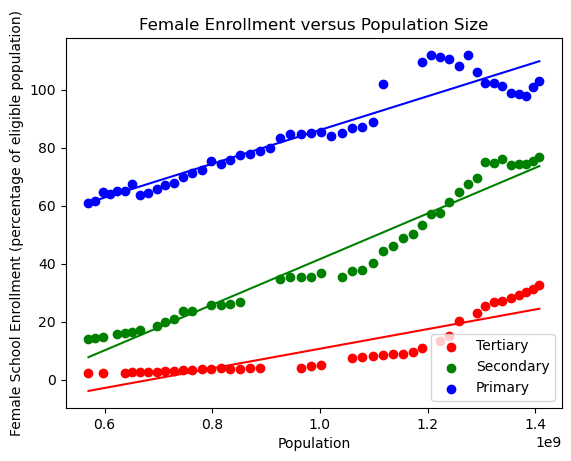

In [96]:
# visualize the relationship between female education and population size

plt.scatter('Population', 'Female Tertiary School Enrollment', data=se_ter_ag_merge, label='Tertiary', color='red')
x = se_ter_ag_merge['Population']
y = se_ter_ag_merge['Female Tertiary School Enrollment']
coeffs = np.polyfit(x, y, 1)
polynomial = np.poly1d(coeffs)
plt.plot(x, polynomial(x), 'r-')
plt.ylabel('Female Tertiary School Enrollment (percentage of eligible population)')
plt.xlabel('Population')

plt.scatter('Population', 'Female Secondary School Enrollment', data=se_sec_ag_merge, label='Secondary', color='green')
x = se_sec_ag_merge['Population']
y = se_sec_ag_merge['Female Secondary School Enrollment']
coeffs = np.polyfit(x, y, 1)
polynomial = np.poly1d(coeffs)
plt.plot(x, polynomial(x), 'g-')

plt.scatter('Population', 'Female Primary School Enrollment', data=se_pr_ag_merge, label='Primary', color='blue')
x = se_pr_ag_merge['Population']
y = se_pr_ag_merge['Female Primary School Enrollment']
coeffs = np.polyfit(x, y, 1)
polynomial = np.poly1d(coeffs)
plt.plot(x, polynomial(x), 'b-')

plt.ylabel('Female School Enrollment (percentage of eligible population)')
plt.xlabel('Population')
plt.legend(loc='lower right')
plt.title('Female Enrollment versus Population Size')
plt.show()

In [100]:
# visualize the relationship between fertility and female education

vars = {
    "SP.DYN.TFRT.IN": "Total Fertility Rate",
    "SE.PRM.ENRR.FE": "Primary",
    "SE.SEC.ENRR.FE": "Secondary",
    "SE.TER.ENRR.FE": "Tertiary"
}

school = wbdata.get_dataframe(vars,country='IND').dropna().sort_index()

px.scatter(school, 
           x="Total Fertility Rate", 
           y=["Primary",
              "Secondary",
              "Tertiary"
             ], 
           labels={
               'value': 'Enrollment (Female, % Gross)'
           },
           title='Total Fertility Rate versus Female School Enrollment',
           # adjust trendline and trendline_options as necessary
           trendline="ols"
          )